In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
import warnings
warnings.simplefilter("ignore")
plt.style.use("fivethirtyeight")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Reading in the data
events = pd.read_csv("data/events.csv")
matches = pd.read_csv("data/ginf.csv")

In [3]:
# Checking structure of the data
print(events.info())
print(matches.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [4]:
#Looks like the data is spread across two tables, one for matches and one for detailed match events. 
#For this report, I'd like to have the *league* and *season* fields in the *events* table as well. 
#Lets merge those two fields together, taking advantage of that convenient *id_odsp* column.

events = pd.merge(events, matches[["id_odsp","league","season"]], on="id_odsp", how="left")

In [5]:
events.head(2)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,league,season
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.00,2,Hamburg SV,Borussia Dortmund,...,6.00,2.00,0,9.00,2.00,1,1.00,0,D1,2012
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,0,NaN,NaN,0,NaN,0,D1,2012


In [8]:
# Data manipulation
events['is_goal'] = events['is_goal'].astype(bool)
events['bodypart'] = events['bodypart'].astype('category')
events['assist_method'] = events['assist_method'].astype('category')
events['id_odsp'] = events['id_odsp'].astype('category')
events['league'] = events['league'].astype('category')

matches['league'] = matches['league'].astype('category')
matches['season'] = matches['season'].astype('category')

In [9]:
# Replacing league levels with more common names
league_mapping = {'D1': 'Bundesliga', 'E0': 'Premier League', 'F1': 'Ligue 1', 'I1': 'Serie A', 'SP1': 'La Liga'}
events['league'] = events['league'].replace(league_mapping)
matches['league'] = matches['league'].replace(league_mapping)

In [10]:
# Filtering by advanced statistics 
filtered_matches = matches[matches['adv_stats'] == False]

# Select the 'league' and 'season' columns
subset = filtered_matches[['league', 'season']]

# Generate summary statistics
summary = subset.describe(include='all')

print(summary.transpose())

       count unique             top freq
league   930      5  Premier League  820
season   930      3            2012  446


In [11]:
# print(subset.league.value_counts())
print(subset.season.value_counts())

season
2012    446
2013    390
2014     94
2015      0
2016      0
2017      0
Name: count, dtype: int64


We notice the majority of matches that have no advanced statistics are from Premier league, and all of them between the years 2012 and 2014. 
To ensure fairness and credibility when comparing across leagues and teams, lets exclude all match events from those seasons.

In [13]:
# Filtering events for seasons after 2014
events = events[events['season'] > 2014]

# Section 1: Leagues
In this section, We will extract some key statistics about Europe’s top five leagues and see how they compare to each other.

### It's All About the Goals  
We'll begin by identifying which league scored the most goals. To ensure a fair comparison, I'll focus on the ratio of goals per match, given that the Bundesliga has two fewer teams than the other leagues. I'll also include the ratio of goals per shot to get a sense of each league's conversion rates.

In [14]:
matches.head(2)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN


In [15]:
# Calculating total goals
matches["goals"] = matches["fthg"] + matches["ftag"] 

In [16]:
# Total goals per league
goals_per_league = matches.groupby('league')["goals"].sum().reset_index()
# number of matches per league
number_of_matches = matches.groupby("league").size().reset_index(name='number_of_matches')
# Total shots/ attempts per league
shots = events[events["event_type"]==1].groupby('league').size().reset_index(name="shots")

In [17]:
ratios_table = pd.merge(number_of_matches, goals_per_league, on='league')
ratios_table['goals_per_match'] = ratios_table['goals'] / ratios_table['number_of_matches']
#ratios_table = pd.merge(ratios_table, shots, on="league")
ratios_table['goals_per_shot'] = ratios_table['goals'] / shots['shots']

In [18]:
ratios_table = ratios_table.sort_values('goals_per_match', ascending=False)

In [34]:
# Apply formatting
styled_ratios_table = (
    ratios_table.style.format(precision=2).set_properties(**{'text-align': 'left'})
    .bar(subset=['number_of_matches'], color='deepskyblue')
    .bar(subset=['goals'], color='lightgreen')
    .bar(subset=['goals_per_match'], color='orange')
    .bar(subset=['goals_per_shot'], color='magenta')
)

# Display the styled table (for Jupyter Notebook or output to HTML)
styled_ratios_table

,league,number_of_matches,goals,goals_per_match,goals_per_shot
0,Bundesliga,1690,4871,2.88,0.26
4,La Liga,2089,5787,2.77,0.27
1,Premier League,2120,5812,2.74,0.23
3,Serie A,2106,5580,2.65,0.22
2,Ligue 1,2107,5283,2.51,0.24


It seems that across all five leagues, the average is around 2-3 goals per match. Although the Bundesliga had the lowest total number of goals, it boasted the highest goals-per-match rate, highlighting the importance of using ratios instead of just absolute numbers. On the other hand, La Liga achieved the highest conversion rate, with over one in four shots resulting in a goal.

### Rough Play  
Now, let's dive into the statistics for bookings and send-offs across each league. Serie A is often considered Europe’s "roughest" league—let's find out if the numbers support this reputation.

In [262]:
cards = events[(events["event_type"]==4) | (events["event_type"]==5) | (events["event_type"]==6)].groupby("league").size().reset_index(name="total_cards")

In [263]:
cards["cards_per_match"] = cards.total_cards / number_of_matches.number_of_matches

In [264]:
cards = cards.sort_values("cards_per_match", ascending=False)
cards

,league,total_cards,cards_per_match
4,La Liga,5110,2.45
3,Serie A,5042,2.39
2,Ligue 1,3718,1.76
0,Bundesliga,2942,1.74
1,Premier League,3605,1.70


Text(0, 0.5, 'League')

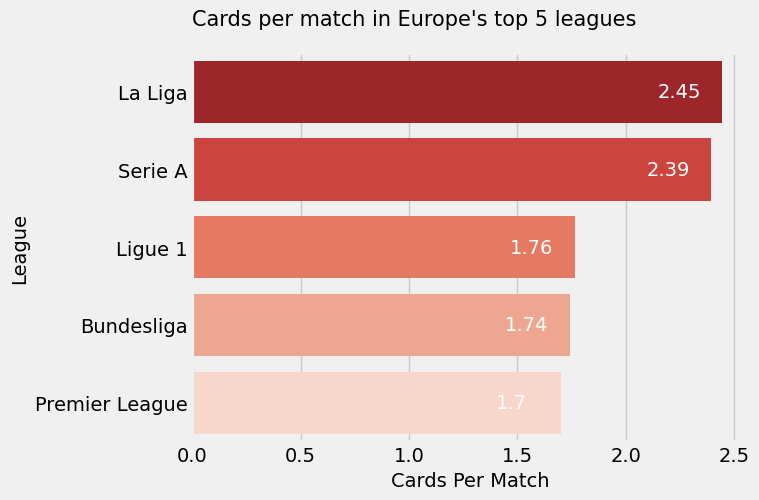

In [265]:
ax = sns.barplot(data=cards, x="cards_per_match", y="league",  palette='Reds_r', order=cards.league)

for index, value in enumerate(cards['cards_per_match']):
    plt.text(value - 0.3, index , f'{round(value,2)}', color='white', ha='left', va='center')

plt.title("Cards per match in Europe's top 5 leagues", fontsize=15, pad=20, loc='left')
plt.xlabel('Cards Per Match', fontsize=14)
plt.ylabel('League', fontsize=14)


Fascinating! This suggests that La Liga and Serie A might truly be the 'roughest' leagues, or perhaps their referees are simply quicker to reach for their cards when fouls occur. Let's dig deeper by examining the number of fouls across each league.

In [266]:
fouls = events[(events["event_type"]==3)].groupby("league").size().reset_index(name='total_fouls')

In [267]:
#cards["fouls_per_match"] = fouls.total_fouls / number_of_matches.number_of_matches

In [268]:
cards = pd.merge(number_of_matches, cards, on='league')
cards

,league,number_of_matches,total_cards,cards_per_match
0,Bundesliga,1690,2942,1.74
1,Premier League,2120,3605,1.70
2,Ligue 1,2107,3718,1.76
3,Serie A,2106,5042,2.39
4,La Liga,2089,5110,2.45


In [269]:
cards = pd.merge(fouls, cards, on='league')
cards

,league,total_fouls,number_of_matches,total_cards,cards_per_match
0,Bundesliga,20424,1690,2942,1.74
1,Premier League,20392,2120,3605,1.70
2,Ligue 1,23640,2107,3718,1.76
3,Serie A,26343,2106,5042,2.39
4,La Liga,22685,2089,5110,2.45


In [271]:
cards['fouls per match'] = cards.total_fouls / cards.number_of_matches

In [272]:
cards

,league,total_fouls,number_of_matches,total_cards,cards_per_match,fouls per match
0,Bundesliga,20424,1690,2942,1.74,12.09
1,Premier League,20392,2120,3605,1.70,9.62
2,Ligue 1,23640,2107,3718,1.76,11.22
3,Serie A,26343,2106,5042,2.39,12.51
4,La Liga,22685,2089,5110,2.45,10.86
